# One Pixel Attack for Fooling Deep Neural Networks
An implementation of the procedure described in https://arxiv.org/abs/1710.08864.

https://github.com/nitarshan/one-pixel-attack


## Setup

In [23]:
# One pixel attack imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, models
from tqdm import tqdm

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")


# DeepLabv2 imports
import argparse
import scipy
import scipy.misc
from scipy import ndimage
import cv2
import easydict
import pickle
import copyreg
import types
from sklearn.metrics import jaccard_similarity_score

from torch.autograd import Variable
import torchvision
#import torchvision.models as models
import torch.backends.cudnn as cudnn
from torch.utils import data
from torchsummary import summary

import sys
import os
import os.path as osp
import random
import csv
import timeit
from multiprocessing import set_start_method, Pool
import collections
from collections import OrderedDict
affine_par = True

import warnings
warnings.simplefilter('ignore')

# CUDA -> change to device 0 or 1
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}


## Train CIFAR VGG16 Model

### Model Definitions

In [3]:
# define cifar model
cifar_model = models.vgg16(pretrained=True, init_weights=True)
cifar_model.classifier = nn.Sequential(
        nn.Linear(512, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )
cifar_model = cifar_model.to(DEVICE)


# define deeplab model
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, dilation=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False) # change
        self.bn1 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False

        padding = dilation
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, # change
                               padding=padding, bias=False, dilation = dilation)
        self.bn2 = nn.BatchNorm2d(planes,affine = affine_par)
        for i in self.bn2.parameters():
            i.requires_grad = False
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4, affine = affine_par)
        for i in self.bn3.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

        
    def forward(self, x):
        
        residual = x
        
        if type(x) is tuple:
            x = x[0]
            residual = x[0]

        out = self.conv1(x)
        out = self.bn1(out)
        out1 = self.relu(out)

        out = self.conv2(out1)
        out = self.bn2(out)
        out2 = self.relu(out)

        out = self.conv3(out2)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out3 = self.relu(out)

        return out3

class Classifier_Module(nn.Module):

    def __init__(self, dilation_series, padding_series, num_classes):
        super(Classifier_Module, self).__init__()
        self.conv2d_list = nn.ModuleList()
        for dilation, padding in zip(dilation_series, padding_series):
            self.conv2d_list.append(nn.Conv2d(2048, num_classes, kernel_size=3, stride=1, padding=padding, dilation=dilation, bias = True))

        for m in self.conv2d_list:
            m.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.conv2d_list[0](x)
        for i in range(len(self.conv2d_list)-1):
            out += self.conv2d_list[i+1](x)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, affine = affine_par)
        for i in self.bn1.parameters():
            i.requires_grad = False
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True) # change
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=1, dilation=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=1, dilation=4)
        self.layer5 = self._make_pred_layer(Classifier_Module, [6,12,18,24],[6,12,18,24],num_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, 0.01)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        #        for i in m.parameters():
        #            i.requires_grad = False

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion or dilation == 2 or dilation == 4:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion,affine = affine_par))
            
        for i in downsample._modules['1'].parameters():
            i.requires_grad = False
        layers = []
        activations = []
        layers.append(block(self.inplanes, planes, stride,dilation=dilation, downsample=downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, dilation=dilation))
            

        return nn.Sequential(*layers)
    
    def _make_pred_layer(self,block, dilation_series, padding_series,num_classes):
        return block(dilation_series,padding_series,num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        return x

class MS_Deeplab(nn.Module):
    def __init__(self,block,num_classes):
        super(MS_Deeplab,self).__init__()
        self.Scale = ResNet(block,[3, 4, 23, 3],num_classes)   #changed to fix #4 

    def forward(self,x):
        output = self.Scale(x) # for original scale
        output_size = output.size()[2]
        input_size = x.size()[2]

        self.interp1 = nn.Upsample(size=(int(input_size*0.75)+1, int(input_size*0.75)+1), mode='bilinear')
        self.interp2 = nn.Upsample(size=(int(input_size*0.5)+1, int(input_size*0.5)+1), mode='bilinear')
        self.interp3 = nn.Upsample(size=(output_size, output_size), mode='bilinear')

        x75 = self.interp1(x)
        output75 = self.interp3(self.Scale(x75)) # for 0.75x scale

        x5 = self.interp2(x)
        output5 = self.interp3(self.Scale(x5))	# for 0.5x scale

        out_max = torch.max(torch.max(output, output75), output5)
        return [output, output75, output5, out_max]

def Res_Deeplab(num_classes=21):
    model = ResNet(Bottleneck,[3, 4, 23, 3], num_classes)
    return model

deeplab_model = Res_Deeplab(num_classes = 21)
deeplab_model.eval()
deeplab_model.cuda(1)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=Fa

### CIFAR Dataloading

In [6]:

BATCH_SIZE = 128
TRAIN_COUNT = 40_000
VAL_COUNT = 10_000
TEST_COUNT = 10_000

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root='/home/m3kowal/Desktop/Research/Datasets/CIFAR', train=True, download=True, transform=train_transform)
train_set = torch.utils.data.dataset.Subset(train_set, range(0,TRAIN_COUNT))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)

val_set = datasets.CIFAR10(root='/home/m3kowal/Desktop/Research/Datasets/CIFAR', train=True, download=True, transform=test_transform)
val_set = torch.utils.data.dataset.Subset(val_set, range(TRAIN_COUNT,TRAIN_COUNT+VAL_COUNT))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

test_set = datasets.CIFAR10(root='/home/m3kowal/Desktop/Research/Datasets/CIFAR', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [16]:
# Evaluation setup
IMG_MEAN = np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)

# DATA_DIRECTORY = 'data/VOCdevkit/VOC2012'
# DATA_LIST_PATH = './dataset/list/val.txt'

DATA_DIRECTORY = '/home/m3kowal/Desktop/Research/Datasets/VOC2012/data/VOCdevkit/VOC2012'
DATA_LIST_PATH = '/home/m3kowal/Desktop/Research/Datasets/VOC2012/dataset/list/val.txt'

IGNORE_LABEL = 255
NUM_CLASSES = 21
NUM_STEPS = 1449 # Number of images in the validation set is 1449
RESTORE_FROM = './deeplab_snapshots/VOC12_scenes_20000.pth'

def get_arguments():
    """Parse all the arguments provided from the CLI.
    
    Returns:
      A list of parsed arguments.
    """
    #parser = argparse.ArgumentParser(description="DeepLabLFOV Network")
    '''parser.add_argument("--data-dir", type=str, default=DATA_DIRECTORY,
                        help="Path to the directory containing the PASCAL VOC dataset.")
    parser.add_argument("--data-list", type=str, default=DATA_LIST_PATH,
                        help="Path to the file listing the images in the dataset.")
    parser.add_argument("--ignore-label", type=int, default=IGNORE_LABEL,
                        help="The index of the label to ignore during the training.")
    parser.add_argument("--num-classes", type=int, default=NUM_CLASSES,
                        help="Number of classes to predict (including background).")
    parser.add_argument("--restore-from", type=str, default=RESTORE_FROM,
                        help="Where restore model parameters from.")
    parser.add_argument("--gpu", type=int, default=0,
                        help="choose gpu device.")
    '''
    args = easydict.EasyDict({
    "data_dir": DATA_DIRECTORY,
    "data_list": DATA_LIST_PATH,
    "ignore_label": IGNORE_LABEL,
    "num_classes": NUM_CLASSES,
    "restore_from": RESTORE_FROM,
    "gpu": 1
    })
    
    return args

def get_iou(data_list, class_num, save_path=None):

    ConfM = ConfusionMatrix(class_num)
    f = ConfM.generateM
    pool = Pool() 
    m_list = pool.map(f, data_list)
    pool.close() 
    pool.join() 
    
    for m in m_list:
        ConfM.addM(m)
    
    aveJ, j_list, M = ConfM.jaccard()
    print('meanIOU: ' + str(aveJ) + '\n')
    
    classes = np.array(('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor'))
    for i in range(len(j_list)):
        print(classes[i], j_list[i])
    
    #if save_path:
     #   with open(save_path, 'w') as f:
            #f.write('meanIOU: ' + str(aveJ) + '\n')
            #f.write(str(j_list)+'\n')
            #f.write(str(M)+'\n')

def show_all(gt, pred):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1, 2)
    ax1, ax2 = axes

    classes = np.array(('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor'))
    
    colormap = [(0,0,0),(0.5,0,0),(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5),(1,1,1)]

    cmap = colors.ListedColormap(colormap)
    bounds=[0,0.5,1.5,2.5,2.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,255]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax1.set_title('gt')
    ax1.imshow(gt, cmap=cmap, norm=norm)

    ax2.set_title('pred')
    ax2.imshow(pred, cmap=cmap, norm=norm)

    plt.show()
    
def show_attack(pred_og, pred_attack):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1, 2, figsize=(15,15))
    ax1, ax2 = axes

    classes = np.array(('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor'))
    
    colormap = [(0,0,0),(0.5,0,0),(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5),(1,1,1)]

    cmap = colors.ListedColormap(colormap)
    bounds=[0,0.5,1.5,2.5,2.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5,13.5,14.5,15.5,16.5,17.5,18.5,19.5,20.5,255]
    norm = colors.BoundaryNorm(bounds, cmap.N)

    ax1.set_title('Prediction Before Attack')
    ax1.imshow(pred_og, cmap=cmap, norm=norm)
    
    ax2.set_title('Prediction After Attack')
    ax2.imshow(pred_attack, cmap=cmap, norm=norm)
    
    plt.show()  

def show_all_binary(gt, pred):
    import matplotlib.pyplot as plt
    from matplotlib import colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    fig, axes = plt.subplots(1, 2)
    ax1, ax2 = axes

    classes = np.array(('background',  # always index 0
               'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor'))
    colormap = [(0,0,0),'yellow',(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5)]
    
    colormap2 = [(0,0,0),'yellow',(0,0.5,0),(0.5,0.5,0),(0,0,0.5),(0.5,0,0.5),(0,0.5,0.5), 
                    (0.5,0.5,0.5),(0.25,0,0),(0.75,0,0),(0.25,0.5,0),(0.75,0.5,0),(0.25,0,0.5), 
                    (0.75,0,0.5),(0.25,0.5,0.5),(0.75,0.5,0.5),(0,0.25,0),(0.5,0.25,0),(0,0.75,0), 
                    (0.5,0.75,0),(0,0.25,0.5)]
    
    cmap = colors.ListedColormap(colormap)
    cmap2 = colors.ListedColormap(colormap2)
    bounds=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
    norm = colors.BoundaryNorm(bounds, cmap.N)
   
    
    ax1.set_title('Groundtruth')
    ax1.imshow(gt, cmap=cmap, norm=norm)

    ax2.set_title('Output')
    ax2.imshow(pred, cmap=cmap, norm=norm)

    plt.show()

# Metric setup
def _pickle_method(m):
    if m.im_self is None:
        return getattr, (m.im_class, m.im_func.func_name)
    else:
        return getattr, (m.im_self, m.im_func.func_name)
copyreg.pickle(types.MethodType, _pickle_method)

class ConfusionMatrix(object):

    def __init__(self, nclass, classes=None):
        self.nclass = nclass
        self.classes = classes
        self.M = np.zeros((nclass, nclass))

    def add(self, gt, pred):
        assert(np.max(pred) <= self.nclass)
        assert(len(gt) == len(pred))
        for i in range(len(gt)):
            if not gt[i] == 255:
                self.M[gt[i], pred[i]] += 1.0

    def addM(self, matrix):
        assert(matrix.shape == self.M.shape)
        self.M += matrix

    def __str__(self):
        pass

    def recall(self):
        recall = 0.0
        for i in range(self.nclass):
            recall += self.M[i, i] / np.sum(self.M[:, i])

        return recall/self.nclass

    def accuracy(self):
        accuracy = 0.0
        for i in range(self.nclass):
            accuracy += self.M[i, i] / np.sum(self.M[i, :])

        return accuracy/self.nclass

    def jaccard(self):
        jaccard = 0.0
        jaccard_perclass = []
        for i in range(self.nclass):
            jaccard_perclass.append(self.M[i, i] / (np.sum(self.M[i, :]) + np.sum(self.M[:, i]) - self.M[i, i]))
        
        return np.sum(jaccard_perclass)/len(jaccard_perclass), jaccard_perclass, self.M

    def generateM(self, item):
        gt, pred = item
        m = np.zeros((self.nclass, self.nclass))
        assert(len(gt) == len(pred))
        for i in range(len(gt)):
            if gt[i] < self.nclass: #and pred[i] < self.nclass:
                m[gt[i], pred[i]] += 1.0
        return m

def confidence_score(pred, gt):
    error_ones = np.where(pred-gt != 0, 1, 0)
    num_errors = np.count_nonzero(error_ones == 1)
    error_percentage = num_errors / gt.size
    return (1-error_percentage)

def binary_IOU(pred, gt):
    #IOU = jaccard_similarity_score(pred, gt)
    add = pred + gt
    intersection = np.count_nonzero(np.where(add > 1, 1, 0))
    union = np.count_nonzero(add)
    IOU = intersection / union
    return IOU

def custom_IOU(pred, gt):
    pred = np.asarray(pred).astype(np.bool)
    gt = np.asarray(gt).astype(np.bool)
    intersection = np.logical_and(pred, gt)
    union = np.logical_or(pred, gt)
    return intersection.sum() / float(union.sum())

# VOC Dataset 
class VOCDataSet(data.Dataset):
    def __init__(self, root, list_path, max_iters=None, crop_size=(321, 321), mean=(128, 128, 128), scale=False, mirror=False, ignore_label=255):
        self.root = root #'/home/m3kowal/Desktop/Class/Project/Pytorch-Deeplab-master/VOCdevkit/VOC2012'
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.scale = scale
        self.ignore_label = ignore_label
        self.mean = mean
        self.is_mirror = mirror
        # self.mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        if not max_iters==None:
            self.img_ids = self.img_ids * int(np.ceil(float(max_iters)/len(self.img_ids)))
        self.files = []
        # for split in ["train", "trainval", "val"]:
        for name in self.img_ids:
            img_file   = osp.join(self.root, "JPEGImages/%s.jpg" % name)
            label_file = osp.join(self.root, "SegmentationClassAug/%s.png" % name)
            self.files.append({
                "img": img_file,
                "label": label_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)


    def __getitem__(self, index):
        datafiles = self.files[index]
        
        #image2 = cv2.imread( datafiles["img"],   cv2.IMREAD_COLOR)
        image = cv2.imread( datafiles["img"],   cv2.IMREAD_COLOR)
        label = cv2.imread(datafiles["label"], cv2.IMREAD_GRAYSCALE)
        

        size = image.shape
        name = datafiles["name"]

        image = np.asarray(image, np.float32)
        image -= self.mean
        img_h, img_w = label.shape
        pad_h = max(self.crop_h - img_h, 0)
        pad_w = max(self.crop_w - img_w, 0)
        
        if pad_h > 0 or pad_w > 0:
            img_pad = cv2.copyMakeBorder(image, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT, 
                value=(0.0, 0.0, 0.0))
            label_pad = cv2.copyMakeBorder(label, 0, pad_h, 0, 
                pad_w, cv2.BORDER_CONSTANT,
                value=(self.ignore_label,))    
        
        else:
            img_pad, label_pad = image, label

        img_h, img_w = label_pad.shape
        
        h_off = random.randint(0, img_h - self.crop_h)
        w_off = random.randint(0, img_w - self.crop_w)
        
        h_off = 0
        w_off = 0
        
        # roi = cv2.Rect(w_off, h_off, self.crop_w, self.crop_h);
        image = np.asarray(img_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        label = np.asarray(label_pad[h_off : h_off+self.crop_h, w_off : w_off+self.crop_w], np.float32)
        #image = image[:, :, ::-1]  # change to BGR
        image = image.transpose((2, 0, 1))
        if self.is_mirror:
            flip = np.random.choice(2) * 2 - 1
            image = image[:, :, ::flip]
            label = label[:, ::flip]

        return image.copy(), label.copy(), np.array(size), name
    
# defining dataloader and upsampling function
args = get_arguments()
VOCDataSet2 = VOCDataSet(args.data_dir,args.data_list, crop_size=(505, 505), mean=IMG_MEAN)
testloader = data.DataLoader(VOCDataSet2, batch_size=1, shuffle=False, pin_memory=True)
interp = nn.Upsample(size=(505, 505), mode='bilinear', align_corners=True)
data_list = []

### Validation Functions

In [17]:
# CIFAR test function
def test(epoch=None, is_validation=False):
    cifar_model.eval()
#     for name, param in cifar_model.named_parameters():
#         param.requires_grad = False
#         print(name, param)
    
    loader = val_loader if is_validation else test_loader
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
#             if batch_idx == 0:
#                 npimg = inputs[1].cpu().numpy()
#                 plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
            outputs = cifar_model(inputs)
#             print('output', outputs[0])
#             print('target', targets[1])
            test_loss += F.cross_entropy(outputs, targets, size_average=False).item()
#            print('------->', outputs.max(1)[1].eq(targets))
            test_correct += outputs.max(1)[1].eq(targets).sum().item()
    if is_validation:
        writer.add_scalar('logs/val_loss', test_loss/len(loader.dataset), epoch)
        writer.add_scalar('logs/val_acc', test_correct/len(loader.dataset), epoch)
    else:
        print("Test Accuracy: {}/{}".format(test_correct, len(loader.dataset)))
             
# DeepLab test function
def test_deeplab():
    """Create the model and start the evaluation process."""
    args = get_arguments()

    gpu0 = args.gpu

    model = Res_Deeplab(num_classes=args.num_classes)
    
    saved_state_dict = torch.load(args.restore_from)
    
    '''#Loading and removing extra term infront of layer names if neccessary
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in saved_state_dict.items():
        name = k[6:] # remove `module.`
        new_state_dict[name] = v
    # load params
    model.load_state_dict(new_state_dict)'''
    
    model.load_state_dict(saved_state_dict)
    
    model.eval()
    model.cuda(gpu0)

    VOCDataSet2 = VOCDataSet(args.data_dir,args.data_list, crop_size=(505, 505), mean=IMG_MEAN, scale=False, mirror=False)
 
    
    testloader = data.DataLoader(VOCDataSet2, batch_size=1, shuffle=False, pin_memory=True)
    
    interp = nn.Upsample(size=(505, 505), mode='bilinear', align_corners=True)
    data_list = []
    
    for index, batch in enumerate(testloader):
        if index % 100 == 0:
            print('%d processd'%(index))
            
        image, label, size, name = batch 
        size = size[0].numpy()
        
        
        output = model(Variable(image).cuda(gpu0))

        
        output = interp(output).cpu().data[0].numpy()
        output = output[:,:size[0],:size[1]]

        
        gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
        
        output = output.transpose(1,2,0)
        output = np.asarray(np.argmax(output, axis=2), dtype=np.int)
        
        if index < 50 == 0:
            show_all(gt, output)
        data_list.append([gt.flatten(), output.flatten()])
    get_iou(data_list, args.num_classes)


### CIFAR - Train Function or Load Weights

In [18]:
#optimizer = optim.Adam(cifar_model.classifier.parameters())
optimizer = optim.Adam(cifar_model.parameters(), lr=0.0001)
for param in cifar_model.parameters():
        param.requires_grad = True
# Training
def train(epoch):
    cifar_model.train()
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = cifar_model(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_correct = outputs.max(1)[1].eq(targets).sum().item()
        epoch_loss += loss.item()
        epoch_correct += batch_correct
        writer.add_scalar('logs/train_loss', loss.item(), epoch*len(train_loader) + batch_idx)
        writer.add_scalar('logs/train_acc', batch_correct / targets.size(0), epoch*len(train_loader) + batch_idx)
    test(epoch, is_validation=True)
    
TRAIN_EPOCHS = 20
WEIGHTS_PATH = Path("/home/m3kowal/Desktop/Research/One Pixel Attack for Dense Prediction/cifar_snapshots/vgg_cifar_weights_lr=0.0001.pt")

if WEIGHTS_PATH.is_file():
    cifar_model.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    for epoch in range(TRAIN_EPOCHS):
        train(epoch)
    torch.save(cifar_model.state_dict(), WEIGHTS_PATH)


Loaded weights from file: /home/m3kowal/Desktop/Research/One Pixel Attack for Dense Prediction/cifar_snapshots/vgg_cifar_weights_lr=0.0001.pt


In [19]:
WEIGHTS_PATH = Path("/home/m3kowal/Desktop/Research/One Pixel Attack for Dense Prediction/cifar_snapshots/vgg_cifar_weights_lr=0.0001.pt")
cifar_model.load_state_dict(torch.load(WEIGHTS_PATH))
test()

Test Accuracy: 8825/10000


## Attack Models

### CIFAR and DEEPLAB Show Functions

In [20]:
CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

DEEPLAB_LABELS = ('background', 'aeroplane', 'bicycle', 'bird', 'boat','bottle', 'bus', 'car', 'cat', 'chair','cow', 
                  'diningtable', 'dog', 'horse','motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell_cifar(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

def show_deeplab(img):
    npimg = img.cpu().data[0].numpy()
    npimg = npimg[:,:size[0],:size[1]]
    print('shape before imshow:', npimg.shape)
    npimg = np.transpose(npimg[::-1,:,:], (1,2,0))
    npimg = (npimg-npimg.min())/(npimg.max()-npimg.min())
    
    plt.figure(figsize=(15,15))
    plt.imshow(npimg)
    plt.show()

def tell_deeplab(img, gt, pred, target_label=None):
    show_deeplab(img)
    show_all(gt, pred)
    print('IOU = ', custom_IOU(gt, pred))


### CIFAR Prediction

True Label: deer 4
Prediction: deer 4
Label Probabilities: tensor([0.0003, 0.0000, 0.0009, 0.0005, 0.9972, 0.0002, 0.0003, 0.0005, 0.0001,
        0.0000], device='cuda:1', grad_fn=<SoftmaxBackward>)
True Label Probability: 0.9972410202026367


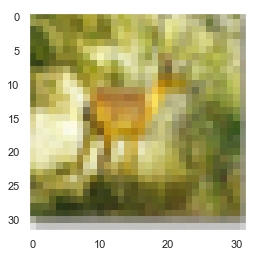

In [21]:
test_img, test_label = test_set[500]
test_img = test_img.to(DEVICE)
show(test_img)
tell_cifar(test_img, test_label, cifar_model)

### DeepLab Prediction

torch.Size([1, 3, 505, 505])
shape before imshow: (3, 366, 500)


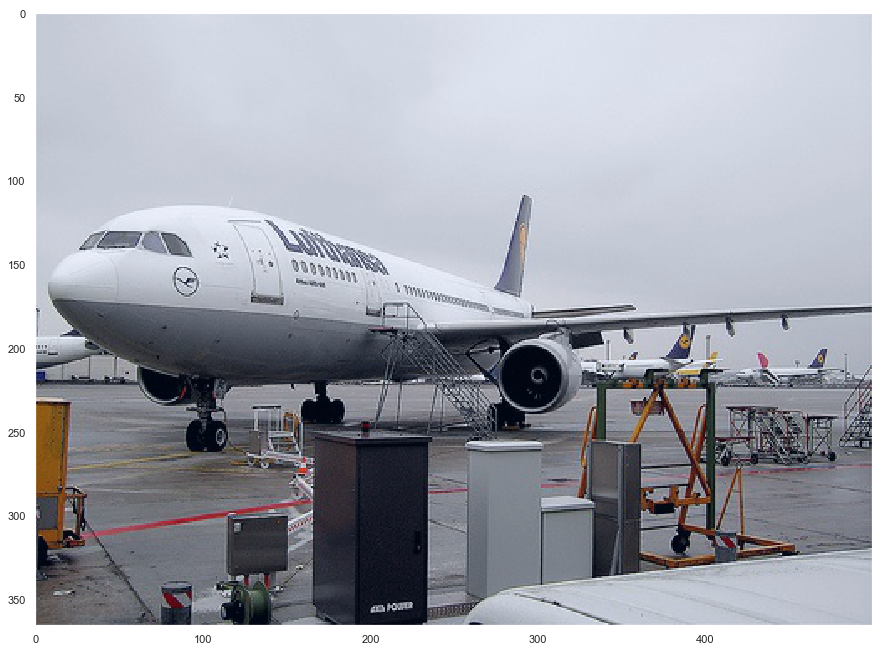

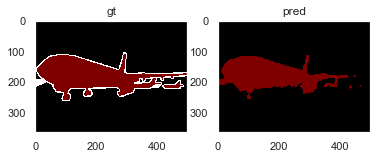

IOU =  0.7342237658656179


In [22]:
# defining dataloader and upsampling function
args = get_arguments()
VOCDataSet2 = VOCDataSet(args.data_dir,args.data_list, crop_size=(505, 505), mean=IMG_MEAN)
testloader = data.DataLoader(VOCDataSet2, batch_size=1, shuffle=False, pin_memory=True)
interp = nn.Upsample(size=(505, 505), mode='bilinear', align_corners=True)
data_list = []
saved_state_dict = torch.load(args.restore_from)
deeplab_model.load_state_dict(saved_state_dict)

for index, batch in enumerate(testloader):
    if index == 0:
        image, label, size, name = batch 
        size = size[0].numpy()
        print(image.shape)
        pred = deeplab_model(Variable(image).cuda(1))
        pred = interp(pred).cpu().data[0].numpy()
        pred = pred[:,:size[0],:size[1]]
        gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
        pred = pred.transpose(1,2,0)
        pred = np.asarray(np.argmax(pred, axis=2), dtype=np.int)
        img = image
        test_img_deeplab = image
        #show_all(gt, pred)
        tell_deeplab(img, gt, pred)
        break

### CIFAR Perturbation

In [ ]:
def perturb(p, img):
    # Elements of p should be in range [0,1]
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
    print("Perturbation:", p)
    show(p_img)
    tell_cifar(p_img, label, model, target_label)


visualize_perturbation(np.array([0.1,1.2,1,0.1,0.8]), test_img, test_label, cifar_model)

### DeepLab Perturbation

In [ ]:
def perturb_deeplab(p, img):
    # Elements of p should be in range [0,1]
    #img = img[:,:,:size[0],:size[1]]
    img_size_h = img.size(2) # C x _H_ x W, assume H == W
    img_size_w = img.size(3)
    p_img = img.data[0].clone()

    peturb_location_xy = [((p[0] * img_size_w).astype(int)),((p[1]* img_size_h).astype(int)) ]
    peturb_location_xy[0] = np.clip(peturb_location_xy[0], 0, img_size_w-1)
    peturb_location_xy[1] = np.clip(peturb_location_xy[1], 0, img_size_h-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,peturb_location_xy[1],peturb_location_xy[0]] = torch.from_numpy(rgb)
    return p_img

def perturb_deeplab_multipix(p, img):
    # Elements of p should be in range [0,1]
    #img = img[:,:,:size[0],:size[1]]
    img_size_h = img.size(2) # C x _H_ x W, assume H == W
    img_size_w = img.size(3)
    p_img = img.data[0].clone()
    
    peturb_locations_xy = []
    for i in p:
        peturb_locations_xy.append( [((i[0] * img_size_w).astype(int)),((i[1]*img_size_h).astype(int))])
    
    for j in range(len(peturb_locations_xy)): 
        peturb_locations_xy[j] = np.clip(peturb_locations_xy[j], 0, img_size_w-1)
        peturb_locations_xy[j] = np.clip(peturb_locations_xy[j], 0, img_size_h-1)
    
    rgb = []
    for k in p:
        rgb.append(k[2:5].copy())
    rgb = np.clip(rgb, 0, 1)
    
    for n in range(len(p)):
        p_img[:,peturb_locations_xy[n][1],peturb_locations_xy[n][0]] = torch.from_numpy(rgb[n])

    return p_img

def deeplab_visualize_perturbation(p, img, model, target_label=None):
    p_img = perturb_deeplab_multipix(p, img)
    
    print("Perturbation:", p)
    show_deeplab(p_img.unsqueeze(0))
    #tell_deeplab(p_img, label, model, target_label)
    return p_img
pixels = np.array([[0.1,0.1,0,0,0],[0.2,0.1,0,0,0],[0.3,0.1,0,0,0], [0.4,0.1,0,0,0], [0.5,0.1,0,0,0],[0.6,0.1,0,0,0]])

attack_image = deeplab_visualize_perturbation(pixels, test_img_deeplab, deeplab_model)

### Untargeted and Targeted Attacks

In [ ]:
def evaluate(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            # fitness line
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

def evaluate_DeepLab(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            # fitness line
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    return np.array(preds)

# evolve function should work for both models
def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

# just change the fitness function should do the trick
def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,5))
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    is_targeted = target_label is not None
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack
_ = attack(cifar_model, test_img, test_label)

In [ ]:
def evaluate_DeepLab(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb_deeplab_multipix(xs, img)
            pred = model(Variable(p_img.unsqueeze(0)).cuda(1))
            pred = interp(pred).cpu().data[0].numpy()
            pred = pred[:,:size[0],:size[1]]
            gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
            pred = pred.transpose(1,2,0)
            pred = np.asarray(np.argmax(pred, axis=2), dtype=np.int)
            img = image
            #tell_deeplab(img, gt, pred)
            preds.append(custom_IOU(gt, pred))
    return np.array(preds)

# evolve function should work for both models
def evolve_DeepLab(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random([5,5])[x_oob]
            gen2[i] = x_next
    return gen2

# just change the fitness function should do the trick
def attack_DeepLab(model, img, num_pix=1, iters=100, pop_size=100, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    
    candidates = np.random.random((pop_size,5, 5))
    
    for i in candidates:
        i[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (5,3)), 0, 1)
    
    fitness = evaluate_DeepLab(candidates, img, label, model)
    fitness_list = []
    def is_success():
        return  fitness.min() < 0.35
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%5 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.min())
            fitness_list.append(fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve_DeepLab(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate_DeepLab(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        attack_img = deeplab_visualize_perturbation(best_solution, img, model)
    
        pred_og = model(Variable(test_img_deeplab).cuda(1))
        pred_og = interp(pred_og).cpu().data[0].numpy()
        pred_og = pred_og[:,:size[0],:size[1]]
        gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
        pred_og = pred_og.transpose(1,2,0)
        pred_og = np.asarray(np.argmax(pred_og, axis=2), dtype=np.int)
    
        p_img = perturb_deeplab_multipix(best_solution, img)
        pred = model(Variable(p_img.unsqueeze(0)).cuda(1))
        pred = interp(pred).cpu().data[0].numpy()
        pred = pred[:,:size[0],:size[1]]
        pred = pred.transpose(1,2,0)
        pred = np.asarray(np.argmax(pred, axis=2), dtype=np.int)
        
        show_attack(pred_og, pred)
        print('IOU BEFORE attack:', custom_IOU(gt, pred_og))
        print('IOU AFTER attack:', custom_IOU(gt, pred))
    return is_success(), best_solution, best_score

# Untargeted attack

deeplab_model = Res_Deeplab(num_classes = 21)
saved_state_dict = torch.load(args.restore_from)
deeplab_model.load_state_dict(saved_state_dict)
deeplab_model.eval()
deeplab_model.cuda(1)

_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 4, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = = 6, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 8, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 10, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 15, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 20, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 30, iters=75, pop_size=250)

In [ ]:
_ = attack_DeepLab(deeplab_model, test_img_deeplab, num_pix = 50, iters=75, pop_size=250)

In [ ]:
def evaluate_DeepLab(candidates, img, label, model):
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb_deeplab(xs, img)
            pred = model(Variable(p_img.unsqueeze(0)).cuda(1))
            pred = interp(pred).cpu().data[0].numpy()
            pred = pred[:,:size[0],:size[1]]
            gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
            pred = pred.transpose(1,2,0)
            pred = np.asarray(np.argmax(pred, axis=2), dtype=np.int)
            img = image
            #tell_deeplab(img, gt, pred)
            preds.append(custom_IOU(gt, pred))
    return np.array(preds)

# evolve function should work for both models
def evolve_DeepLab(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

# just change the fitness function should do the trick
def attack_DeepLab(model, img, iters=50, pop_size=100, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    # Untargeted: minimize true_label otherwise (early stop < 5%)
    candidates = np.random.random((pop_size,5))
    
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    fitness = evaluate_DeepLab(candidates, img, label, model)
    fitness_list = []
    def is_success():
        return  fitness.min() < 0.35
    
    for iteration in range(iters):
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%5 == 0: # Print progress
            print("Target Probability [Iteration {}]:".format(iteration), fitness.min())
            fitness_list.append(fitness.min())
        # Generate new candidate solutions
        new_gen_candidates = evolve_DeepLab(candidates, strategy="resample")
        # Evaluate new solutions
        new_gen_fitness = evaluate_DeepLab(new_gen_candidates, img, label, model)
        # Replace old solutions with new ones where they are better
        successors = new_gen_fitness < fitness
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        attack_img = deeplab_visualize_perturbation(best_solution, img, model)
    
        pred_og = model(Variable(test_img_deeplab).cuda(1))
        pred_og = interp(pred_og).cpu().data[0].numpy()
        pred_og = pred_og[:,:size[0],:size[1]]
        gt = np.asarray(label[0].numpy()[:size[0],:size[1]], dtype=np.int)
        pred_og = pred_og.transpose(1,2,0)
        pred_og = np.asarray(np.argmax(pred_og, axis=2), dtype=np.int)
    
        p_img = perturb_deeplab(best_solution, img)
        pred = model(Variable(p_img.unsqueeze(0)).cuda(1))
        pred = interp(pred).cpu().data[0].numpy()
        pred = pred[:,:size[0],:size[1]]
        pred = pred.transpose(1,2,0)
        pred = np.asarray(np.argmax(pred, axis=2), dtype=np.int)
        
        show_attack(pred_og, pred)
        print('IOU BEFORE attack:', custom_IOU(gt, pred_og))
        print('IOU AFTER attack:', custom_IOU(gt, pred))
    return is_success(), best_solution, best_score

# Untargeted attack

deeplab_model = Res_Deeplab(num_classes = 21)
saved_state_dict = torch.load(args.restore_from)
deeplab_model.load_state_dict(saved_state_dict)
deeplab_model.eval()
deeplab_model.cuda(1)


_ = attack_DeepLab(deeplab_model, test_img_deeplab)

In [ ]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(cifar_model, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

In [ ]:
%load_ext watermark
%watermark --updated --datename --python --machine --watermark -p torch,numpy,matplotlib,tensorboardX,torchvision,seaborn,tqdm